# Place features

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from gedcom5.parser import GEDCOM5Parser
from gedcom5.tag import PLAC
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

from common import walk

## Extract data

### Parse GEDCOM file

In [2]:
parser = GEDCOM5Parser()

with open("data/royal92.ged") as f:
    gedcom = parser.parse_string(f.read())

### Extract place names

In [3]:
places = [tag.value for tag in walk(gedcom) if isinstance(tag, PLAC)]
len(places)

1341

## Generate features from text similarity

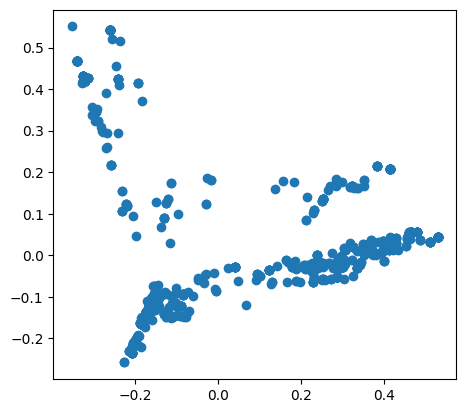

In [4]:
n_neighbors = len(places) - 1

pipeline = make_pipeline(
    CountVectorizer(),
    Isomap(n_neighbors=n_neighbors, metric="cosine"),
)
features = pipeline.fit_transform(places)

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(*features.T);

## Export features

In [5]:
df = pd.DataFrame(
    {
        "place": places,
        "place_0": features[:, 0],
        "place_1": features[:, 1],
    }
)
df.to_csv("data/places.csv", index=False)
df

,place,place_0,place_1
0,"Kensington,Palace,London,England",0.458468,0.054688
1,"Osborne House,Isle of Wight,England",0.209718,-0.032691
2,"Royal Mausoleum,Frogmore,Berkshire,England",0.238519,-0.020116
3,"Schloss Rosenau,Near Coburg,Germany",-0.189654,-0.194401
4,"Windsor Castle,Berkshire,England",0.286371,-0.053135
...,...,...,...
1336,Frederiksborg,-0.160424,-0.116100
1337,"Oldenburg,Germany",-0.205512,-0.218970
1338,Compiegne,-0.147261,-0.092953
1339,"London,England",0.529535,0.044077


## Example clustering to explore groups

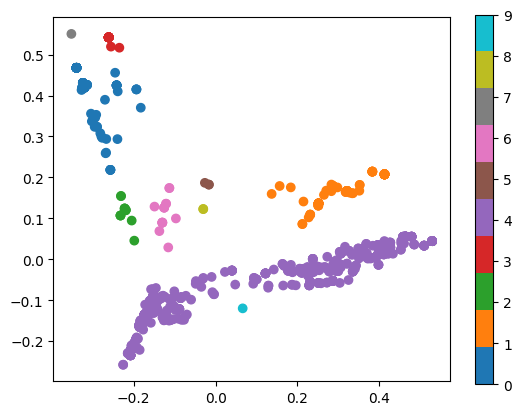

In [6]:
clustering = AgglomerativeClustering(n_clusters=10, linkage="single")
labels = clustering.fit_predict(features)

fig, ax = plt.subplots()
ax.set_aspect(1)
p = ax.scatter(*features.T, c=labels, cmap="tab10")
fig.colorbar(p);

In [7]:
df["label"] = labels
df.sort_values("label").groupby("label").head(1)

,place,place_0,place_1,label
508,"Paris,France",-0.340183,0.467939,0
444,"St. James Palace,London,England",0.413089,0.207476,1
857,Le Mans,-0.231240,0.154379,2
1097,"St. Denis,France",-0.261298,0.542452,3
926,"Westminster,Abbey,London,England",0.426856,0.024690,4
952,St. Paul's,-0.026144,0.186681,5
831,"St. Petersburg,Russia",-0.125730,0.125984,6
1135,France,-0.352585,0.550885,7
1142,"Winter Palace,,St. Petersburg,Russia",-0.030148,0.122574,8
814,"Winchester,Castle",0.066316,-0.120292,9
